In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation")
!ls

 data_balanced_1000.obj     elliptic_txs_edgelist.csv   GRL.ipynb
 data_balanced_500.obj	    elliptic_txs_features.csv   NoteBooks
 data.obj		    GRL_2.ipynb
 elliptic_txs_classes.csv  'GRL_FINAL (4).ipynb'


In [ ]:
#PYTORCH INSTALL
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [4]:
import pickle   
import torch
from torch_geometric.data import Data

fileObj = open('data.obj', 'rb')
data3 = pickle.load(fileObj)
fileObj.close()
print(data3)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], n_id=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])


In [5]:
#USE GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#EDW NA DW ALLES PERIPTWSEIS GIA BATCHES!!!
#Epishs na dw th lista me tous geitones
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(data3,num_neighbors=[-1, -1], shuffle=True,batch_size=203769)

counter = 0
for batch in train_loader:

    print(len(batch.n_id))
    print(len(batch.y))
    print(type(batch))
    print(batch.test_mask)

203769
203769
<class 'torch_geometric.data.data.Data'>
tensor([False,  True, False,  ..., False, False, False])


In [ ]:
#SCRIPT 16
#METRICS
!pip install torchmetrics
from torchmetrics.classification import AUROC
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassAUROC



def conf_matrix(pred_y, y):
  confmat = BinaryConfusionMatrix().to(device)

  return confmat(pred_y, y)

def brecall(pred_y, y):
  #recall = BinaryRecall().to(device)
  recall = MulticlassRecall(num_classes=2, average=None).to(device)

  return recall(pred_y, y)

def bprecision(pred_y, y):
  precision = MulticlassPrecision(num_classes=2, average=None).to(device)

  return precision(pred_y, y)

def auc_roc(pred_y, y):
  aucroc = AUROC(task="binary")
  print(pred_y.shape)
  print(y.shape)
  #aucroc = MulticlassAUROC(num_classes=2, average=None, thresholds=None).to(device)

  return aucroc(pred_y, y)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item() 


In [20]:
def train(model,loader,epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer

    train_loss_total = []
    val_loss_total = []
    best_model = model
    best_val_loss = 1000.0

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0
      auc_roc_train = 0
      auc_roc_val = 0 
      pre_train = 0 
      pre_val = 0
      recall_train = 0
      recall_val = 0
 
      # Train on batches
      for batch in loader:
        optimizer.zero_grad()
        
        _, out = model(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss

        acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        auc_roc_train += auc_roc(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        pre_train += bprecision(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        recall_train += brecall(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        conf_matrix_train = conf_matrix(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        print(conf_matrix_train)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])

        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
        auc_roc_val += auc_roc(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
        pre_val += bprecision(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
        recall_val += brecall(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
        conf_matrix_val = conf_matrix(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
        print(conf_matrix_val)

        print("Train accuracy = ", acc/len(train_loader), "Val accuracy = ", val_acc/len(train_loader))
        print("AUC ROC SCORE TRAIN = ",auc_roc_train/len(train_loader),"AUC ROC SCORE VAL = ", auc_roc_val/len(train_loader))
        print("precision SCORE TRAIN = ",pre_train/len(train_loader),"precision SCORE VAL = ", pre_val/len(train_loader))
        print("RECALL SCORE TRAIN = ",recall_train/len(train_loader),"RECALL SCORE VAL = ", recall_val/len(train_loader))

      if(val_loss < best_val_loss):
        best_val_loss = val_loss
        best_model = model
        print("NEW BEST")
      train_loss_total.append(total_loss)
      val_loss_total.append(val_loss)
      
    return best_model, train_loss_total, val_loss_total

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    auc_roc_acc = auc_roc(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    precision_score = bprecision(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    recall_score = brecall(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    conf_mat = conf_matrix(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])

    return acc, auc_roc_acc, precision_score, recall_score, conf_mat




In [22]:
#TRAIN FUNC 2 WITH WEIGTHS
weights = [4.0, 1.0]
class_weights = torch.FloatTensor(weights).to(device)

def train2(model, data, epochs,wei):
    criterion = torch.nn.CrossEntropyLoss(weight=wei)
    optimizer = model.optimizer
    

    model.train()

    train_loss_total = []
    val_loss_total = []
    best_model = model
    best_val_loss = 1000.0
    
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0
      auc_roc_train = 0
      auc_roc_val = 0 
      pre_train = 0 
      pre_val = 0
      recall_train = 0
      recall_val = 0
 
      # Train on batches
      
      optimizer.zero_grad()
        
      _, out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      total_loss += loss

      acc += accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      auc_roc_train += auc_roc(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      pre_train += bprecision(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      recall_train += brecall(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      conf_matrix_train = conf_matrix(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      print(conf_matrix_train)
      loss.backward()
      optimizer.step()

        # Validation
      val_loss += criterion(out[data.val_mask], data.y[data.val_mask])

      val_acc += accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      auc_roc_val += auc_roc(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      pre_val += bprecision(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      recall_val += brecall(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      conf_matrix_val = conf_matrix(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      print(conf_matrix_val)

      print("Train accuracy = ", acc, "Val accuracy = ", val_acc)
      print("AUC ROC SCORE TRAIN = ",auc_roc_train,"AUC ROC SCORE VAL = ", auc_roc_val)
      print("precision SCORE TRAIN = ",pre_train,"precision SCORE VAL = ", pre_val)
      print("RECALL SCORE TRAIN = ",recall_train,"RECALL SCORE VAL = ", recall_val)

    if(val_loss < best_val_loss):
      best_val_loss = val_loss
      best_model = model
      print("NEW BEST")
    train_loss_total.append(total_loss)
    val_loss_total.append(val_loss)  

    return best_model, train_loss_total, val_loss_total  

In [10]:
import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
#HYPER PARAMETERS DICTIONARYS
#FOR GAT
hp_params_GAT = []
one = {"layers": 2, "loader": 1, "emb_size": 64, "heads":8}#THIS IS FROM
two = {"layers": 2, "loader": 0, "emb_size": 64, "heads":4}
three = {"layers": 2, "loader": 0, "emb_size": 64, "heads":8}
four = {"layers": 2, "loader": 1, "emb_size": 128, "heads":8}
five = {"layers": 3, "loader": 1, "emb_size": 64, "heads":8}
hp_params_GAT.append(one)
hp_params_GAT.append(two)
hp_params_GAT.append(three)
hp_params_GAT.append(four)
hp_params_GAT.append(five)

class GATmodel(torch.nn.Module):
    def __init__(self,layers,emb_size,head_num):
        super(GATmodel, self).__init__()
        self.hid = emb_size
        self.in_head = head_num
        self.out_head = 1
        self.layers = layers
        
        if self.layers == 3:
          self.conv1 = GATConv(165, self.hid, heads=self.in_head, dropout=0.6)
          self.conv = GATConv(self.hid*self.in_head, self.hid, heads=self.in_head, dropout=0.6)
          self.conv2 = GATConv(self.hid*self.in_head, 2, concat=False, heads=self.out_head, dropout=0.6)
          self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
        else:
          self.conv1 = GATConv(165, self.hid, heads=self.in_head, dropout=0.6)
          self.conv2 = GATConv(self.hid*self.in_head, 2, concat=False, heads=self.out_head, dropout=0.6)
          self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)  
          

    def forward(self,x, edge_index):
        
        # Dropout before the GAT layer is used to avoid overfitting

        if self.layers == 3:

          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv1(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv2(x, edge_index)
        else:
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv1(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv2(x, edge_index)
            
        return x,F.log_softmax(x, dim=1)    


In [ ]:
gat_model3 = GATmodel(2,8,8).to(device)
data3 = data3.to(device)
print(gat_model3)

best, trai_lo, val_lo = train(gat_model3,train_loader,200)

In [17]:
print(len(val_lo))

201


In [12]:
#TEST SET FOR GAT
#APO OTI FENETAI MA8AINEI NA DIALEGEI PANTA THN MAJORITY CLASS ISWS POLLA HEADS
acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, conf_mat_GAT = test(best,data3)

print(acc_GAT)
print(auc_roc_acc_GAT)
print(precision_score_GAT)
print(recall_score_GAT)
print(conf_mat_GAT)

torch.Size([29064])
torch.Size([29064])
0.9124345779418945
tensor(0.5000, device='cuda:0')
tensor([0.0000, 0.9124], device='cuda:0')
tensor([0., 1.], device='cuda:0')
tensor([[    0,  2545],
        [    0, 26519]], device='cuda:0')


In [ ]:
gat_model7 = GATmodel(2,8,8).to(device)
data3 = data3.to(device)
print(gat_model7)

best, val, trainl = train2(gat_model7,data3,200,class_weights)

In [26]:
import os
a = os.path.isdir('GAT')
print(a)
os.mkdir("GAT")
a = os.path.isdir('GAT')
print(a)

False
True


NameError: ignored

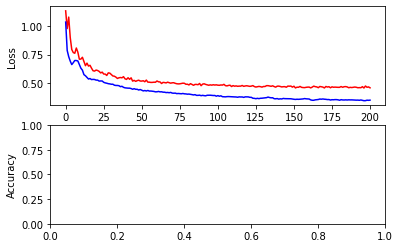

In [19]:
import torch
val2 = torch.stack(trai_lo).cpu().detach().numpy()
train2 = torch.stack(val_lo).cpu().detach().numpy()
fig, ax = plt.subplots(2)

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')

ax[0].plot(val2, color='red') 
ax[0].plot(train2, color='blue') 

#ax[1].plot(history.history['accuracy'], color='red') 
#ax[1].plot(history.history['val_accuracy'], color='blue') 

filename2 = 'train_history'+str(arch)+'.png'
fig.savefig(filename2)
plt.show()

In [ ]:
#TEST SET FOR GAT
#APO OTI FENETAI MA8AINEI NA DIALEGEI PANTA THN MAJORITY CLASS ISWS POLLA HEADS
acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, conf_mat_GAT = test(best,data3)

print(acc_GAT)
print(auc_roc_acc_GAT)
print(precision_score_GAT)
print(recall_score_GAT)
print(conf_mat_GAT)

In [ ]:
import itertools

layers = [2,3]
embe = [64,128]
loader = [0,1]
heads = [4,8]
counter = 0
for xs in itertools.product(layers, embe, loader, heads):
  counter = counter +1
  print(xs)
print(counter)